**Introduction**

In this notebook, I use preprocessed_data csv file for clustering using LDA. 
Using final_data file for Kmeans, but the kmeans took long time to run. Be careful!



*   Result: LDA model, CountVecorizer model, topic data



In [1]:
import pickle
import pandas as pd

import spacy
import spacy.cli
from scipy import spatial
spacy.cli.download("en_core_web_md")
nlp = spacy.load('en_core_web_md')

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Loading Data**

In [3]:
!cp drive/MyDrive/ActionLearning/preprocessed_data.csv .
!cp drive/MyDrive/ActionLearning/topic_data.csv .
!cp drive/MyDrive/ActionLearning/Final_Data.csv .
!cp drive/MyDrive/ActionLearning/Stop_words.csv .

In [4]:
df_master = pd.read_csv('preprocessed_data.csv')
df_master.head()

,Number,Priority,Incident_area,Short_description,Description,Assignment_group,Resolution_notes
0,INC0284448,P2 - High,SAP :: Sonda Procwork (PRW),VF - Not working,"Please, the transaction VF is not working, we ...",IMT APS SAP Order to Cash L2,"Hello Daniel,Many thanks for your reply, at ti..."
1,INC0284449,P4 - Low,SAP :: Technical,Enqueue Processing,Alert Details: Name....................Enqueue...,IMT TCS SAP Basis,Monitoring the lock entries in P via incident ...
2,INC0180368,P2 - High,Infrastructure & Servers :: Server (physical/v...,GOYCSMDC.ds.givaudan.com (Server does not comm...,"Dear Team,We received a ticket from our monito...",IMT NLI Ops EAME,There was a planned maintenance onsite that wa...
3,INC0180373,P3 - Moderate,SAP :: Order to Cash (OTC),I cant connect to ESKER PRD & UAT,"I already got access for ESKER QA, UAT & PRD. ...",IMT Desktop Infra Support Indonesia,User confirmed issue was solved
4,INC0180380,P3 - Moderate,Business Application :: Google,I cannot access my google drive shortcut from ...,I cannot access my google drive shortcut from ...,IMT Service Desk AME,"User G drive was inactive, i reconfigured it, ..."


In [5]:
# Embedded data for K-means cluster
embedded_data = pd.read_csv('Final_Data.csv', header=None)
embedded_data.shape

(103346, 300)

In [6]:
embedded_data[:2]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
0,-0.054271,0.130692,-0.137513,0.034790,0.096651,-0.000966,-0.143119,-0.22029,0.024923,1.146100,-0.160211,0.228671,-0.010778,-0.131768,0.075039,0.024887,-0.039821,1.087538,0.141027,0.037318,0.055200,0.034249,-0.122054,-0.112340,-0.091150,-0.074428,0.040035,-0.079109,0.012974,0.108200,0.014539,-0.203156,0.042589,0.108771,-0.079840,0.114576,0.194709,-0.089859,0.060279,-0.170358,...,0.070948,0.041571,0.016427,0.137908,-0.106695,-0.142898,0.043619,0.187453,0.403941,-0.224937,0.063775,0.024220,-0.027867,0.124800,0.031980,0.110535,-0.154252,-0.006666,0.055827,-0.090440,0.008006,0.030003,0.154892,-0.010627,-0.014212,0.149345,0.051741,-0.035239,0.088791,-0.043869,-0.313357,-0.065391,-0.017782,0.110310,0.108043,-0.308556,-0.014451,-0.062027,-0.021858,0.168944
1,-0.086554,-0.007773,-0.121346,0.065881,-0.046053,0.112583,-0.054858,-0.19566,-0.003710,1.567562,-0.218406,-0.000245,0.038233,-0.123520,-0.060072,0.005209,-0.096698,1.598871,-0.012681,-0.130734,0.061867,-0.014848,-0.160658,-0.083903,-0.009564,0.139925,-0.003305,-0.131822,0.109193,-0.146462,-0.022046,-0.039282,0.204670,0.049280,-0.143936,0.027563,-0.116466,0.130115,-0.010970,-0.127870,...,0.141384,0.080649,0.067504,-0.080307,-0.059306,-0.147814,0.088873,0.104042,0.776709,-0.130269,-0.007333,0.081728,0.061907,-0.082988,0.123276,0.042795,0.001605,0.153446,0.064448,0.107337,0.045912,0.042989,0.249911,-0.097046,-0.040757,-0.049607,0.142084,-0.008197,0.166199,-0.141038,-0.144507,0.341765,0.013559,0.145051,0.163032,-0.212058,-0.229798,-0.015879,0.003460,0.090798


**LDA**

In [7]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.feature_extraction import text 

In [8]:
# Stop Words
df_stopWords = pd.read_csv("Stop_words.csv")['Word']
stopWords = text.ENGLISH_STOP_WORDS.union(df_stopWords)

In [9]:
df_master['Description'].shape

(103346,)

In [10]:
# Count Vectorizer on Description column
cv = CountVectorizer(max_df=0.95, min_df=2, stop_words=stopWords, max_features=500)
cv_model = cv.fit(df_master['Description'])

In [11]:
dtm = cv_model.transform(df_master['Description'])

In [12]:
LDA = LatentDirichletAllocation(n_components=50,random_state=42)
LDA.fit(dtm)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=50, n_jobs=None,
                          perp_tol=0.1, random_state=42, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

In [13]:
# Save LDA Model
pickle.dump(LDA, open('LDA_models_50.pkl', 'wb'))

In [15]:
# Save countvectorizer model
pickle.dump(cv_model, open('CV_model.pkl', 'wb'))

In [14]:
LDA.transform(dtm).argmax(axis=1)

array([ 3, 13, 45, ...,  0,  6, 22])

**Prediction and Show top 10 cluster**

*Assign topic label and save*

In [17]:
columns = ['Number', 'Priority', 'Incident_area', 
           'Short_description', 'Description', 'Assignment_group', 'Resolution_notes']

df_LDA = df_master[columns].copy()
df_LDA['topic'] = LDA.transform(dtm).argmax(axis=1)
df_LDA.head()

,Number,Priority,Incident_area,Short_description,Description,Assignment_group,Resolution_notes,topic
0,INC0284448,P2 - High,SAP :: Sonda Procwork (PRW),VF - Not working,"Please, the transaction VF is not working, we ...",IMT APS SAP Order to Cash L2,"Hello Daniel,Many thanks for your reply, at ti...",3
1,INC0284449,P4 - Low,SAP :: Technical,Enqueue Processing,Alert Details: Name....................Enqueue...,IMT TCS SAP Basis,Monitoring the lock entries in P via incident ...,13
2,INC0180368,P2 - High,Infrastructure & Servers :: Server (physical/v...,GOYCSMDC.ds.givaudan.com (Server does not comm...,"Dear Team,We received a ticket from our monito...",IMT NLI Ops EAME,There was a planned maintenance onsite that wa...,45
3,INC0180373,P3 - Moderate,SAP :: Order to Cash (OTC),I cant connect to ESKER PRD & UAT,"I already got access for ESKER QA, UAT & PRD. ...",IMT Desktop Infra Support Indonesia,User confirmed issue was solved,6
4,INC0180380,P3 - Moderate,Business Application :: Google,I cannot access my google drive shortcut from ...,I cannot access my google drive shortcut from ...,IMT Service Desk AME,"User G drive was inactive, i reconfigured it, ...",40


In [18]:
df_LDA.to_csv("topic_data.csv", index = False)

*Top 10 cluster*

In [20]:
hist_top_10 = df_LDA['topic'].value_counts().sort_values()[-10:]
hist_top_10

41    3293
12    3297
22    3376
18    3557
33    3569
34    4319
5     5371
2     7502
3     7953
0     9902
Name: topic, dtype: int64

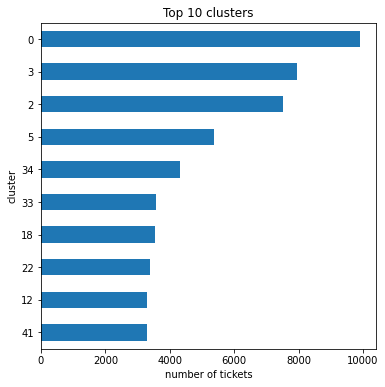

In [21]:
ax = hist_top_10.plot.barh(title='Top 10 clusters', figsize=(6, 6))
ax.set_ylabel('cluster')
ax.set_xlabel('number of tickets')
pass

In [22]:
# Save
ax.figure.savefig('top_10.png', dpi=ax.figure.dpi)

In [23]:
hist_top_10.index

Int64Index([41, 12, 22, 18, 33, 34, 5, 2, 3, 0], dtype='int64')

*Test*

In [24]:
text = "Hi Team, Bank statement file for ID13 HR has not been automatically uploaded since Jan 1. ID13 DB statement 31.12.2019 (IDR & EUR) not upload into SAP. Today is our closing day and the statement need to be posted and settle by today. Kindly assist. I will upload the txt file manually if needed."
data_test = cv_model.transform([text])

In [25]:
pred = LDA.transform(data_test).argmax(axis=1)

In [26]:
import joblib
test_cv_model = joblib.load("CV_model.pkl")
test = test_cv_model.transform([text])

In [27]:
topic = LDA.components_[pred[0]]
[cv_model.get_feature_names()[i] for i in topic.argsort()[-10:]]
# topic.argsort()[-15:]
# topic.shape

['action',
 'share',
 'scan',
 'path',
 'detected',
 'installed',
 'files',
 'ip',
 'machine',
 'file']

**Kmeans-Cluster**

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [ ]:
K = [5, 30, 50, 100, 300, 900]

In [ ]:
distortions = []

for k in K:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(embedded_data)
    distortions.append(kmeans.inertia_)

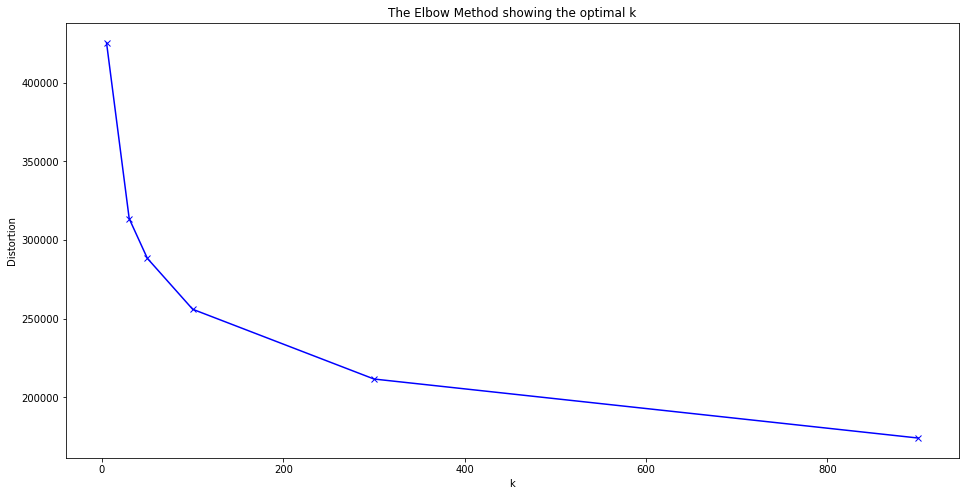

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [ ]:
kmeansModel = KMeans(n_clusters=50)
kmeansModel.fit(embedded_data)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=50, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

*Saving the model*

In [ ]:
pickle.dump(kmeansModel, open('kmeans_model_50.pkl', 'wb'))

**GMM Clustering**

In [ ]:
from sklearn.mixture import GaussianMixture
import numpy as np

In [ ]:
lowest_bic = np.infty
bic = []
n_components_range = [5, 30, 50, 100, 300, 900]

for n_components in n_components_range:
    # Fit a Gaussian mixture with EM
    gmm = GaussianMixture(n_components=n_components, covariance_type='full')
    gmm.fit(embedded_data)
    bic.append(gmm.bic(embedded_data))
    if bic[-1] < lowest_bic:
        lowest_bic = bic[-1]
        best_gmm = gmm

/usr/local/lib/python3.7/dist-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


KeyboardInterrupt: ignored

In [ ]:
best_gmm